In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf

plt.rcParams['font.size'] = 14

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Visualization of Augmentation Techniques
- In the cells below you can try to observe the effects of some of the augmentation techniques
- Please refer to this page for understanding the different augmentation techniques available: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- Augmentation can be both Image Transformation based or Image Filtering based

<img src='https://miro.medium.com/max/1400/0*0Je9h2iT9m7ribFJ.png'>

In [3]:
datagen = ImageDataGenerator(brightness_range=[0.2,1.2],zoom_range=0.25)

In [ ]:
img = load_img('/kaggle/input/dogs-cats-images/dataset/training_set/cats/cat.10.jpg',target_size=(150,150))
img = img_to_array(img)/255.
plt.imshow(img)

In [ ]:
img = np.expand_dims(img,axis=0)

## Visualization of 15 Augmented Samples

In [ ]:
i = 0
plt.figure(figsize=(20,20))
for batch in datagen.flow(img, batch_size=1):
    i += 1
    plt.subplot(5 , 5,  i)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.1)
    plt.imshow(batch[0]/255.)
    plt.axis('off')
    if i > 14:
        break

# ImageDataGenerator
- Generate batches of tensor image data with real-time data augmentation
- Set the batch size and image resolution size for the image data generator

<img src='https://miro.medium.com/max/1770/1*PNW2zbVxS5YnG1z9rUevnQ.png'>

In [4]:
img_size = 150
batch_size = 32


# train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   brightness_range=[0.2,1.2],
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '../input/dogs-cats-images/dataset/training_set',  
        target_size=(img_size, img_size),  
        batch_size=batch_size,
        shuffle=True,
        class_mode='binary') 

validation_generator = test_datagen.flow_from_directory(
        '../input/dogs-cats-images/dataset/test_set',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=False,
        class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Visulization of 15 Random Samples from a Batch of 32

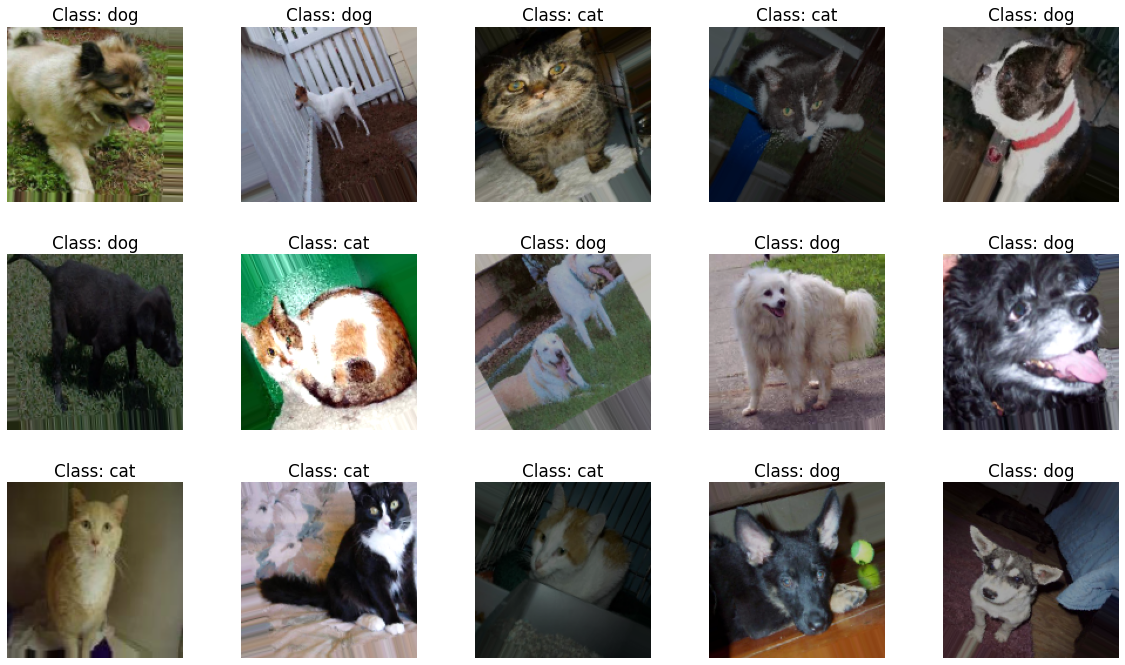

In [5]:
labels = ['cat','dog']
samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

# Model Definition

<h2>1. Sequential API</h2>
- Here we create the model layer-by-layer. It is very simple and easy to use. But sharing of layers or branching of layers is not allowed (We will see what sharing or branching means later). Also, you can’t have multiple inputs or outputs.
<h2>2. Functional API</h2>
- It is more flexible than the sequential API. It is more powerful than the sequential API in the sense branching or sharing of layers is allowed here. And also it can have multiple inputs and outputs.
<h2>3. Subclassing API</h2>
- You implement everything from scratch on your own. Use this if you have complex, out-of-the-box research use cases.
<br>
<img src='https://miro.medium.com/max/1200/1*WzwKtnA0LEhiCGdWTTpLaA.png'>

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Layer, Flatten, Dense, Input

## Sequential API

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(150,150,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

## Functional API
- We will be using this for many advanced architectures in the future
- Since the model has been redefined using the functional api, the functional api model will considered for the rest of the code

In [7]:
input_layer = Input(shape=(150,150,3))
x = Conv2D(32, (3,3), input_shape=(150,150,3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer,outputs=output_layer)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0     

In [9]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

# Model Callbacks
- Save the best converged model using checkpointing
- We will use EarlyStopping in later versions of the code, it is for stopping the training process if the loss does not converge for n subsequent epochs

<img src='https://miro.medium.com/max/973/1*nhmPdWSGh3ziatQKOmVq0Q.png'>

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [11]:
filepath= "model_cnn.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)

In [12]:
history = model.fit(train_generator,epochs=5,
                    validation_data=validation_generator,
                    callbacks=[checkpoint])

Epoch 1/5
250/250 [==============================] - 130s 493ms/step - loss: 0.7209 - accuracy: 0.4988 - val_loss: 0.6927 - val_accuracy: 0.5010

Epoch 00001: val_loss improved from inf to 0.69271, saving model to model_cnn.h5
Epoch 2/5
250/250 [==============================] - 71s 285ms/step - loss: 0.6908 - accuracy: 0.5359 - val_loss: 0.6781 - val_accuracy: 0.5345

Epoch 00002: val_loss improved from 0.69271 to 0.67806, saving model to model_cnn.h5
Epoch 3/5
250/250 [==============================] - 70s 281ms/step - loss: 0.6741 - accuracy: 0.5695 - val_loss: 0.6362 - val_accuracy: 0.6535

Epoch 00003: val_loss improved from 0.67806 to 0.63618, saving model to model_cnn.h5
Epoch 4/5
250/250 [==============================] - 70s 281ms/step - loss: 0.6380 - accuracy: 0.6270 - val_loss: 0.6024 - val_accuracy: 0.6855

Epoch 00004: val_loss improved from 0.63618 to 0.60242, saving model to model_cnn.h5
Epoch 5/5
250/250 [==============================] - 71s 284ms/step - loss: 0.6013 

# Learning Curves
- If the difference between the validation loss and training loss is too big then your model is overfitting

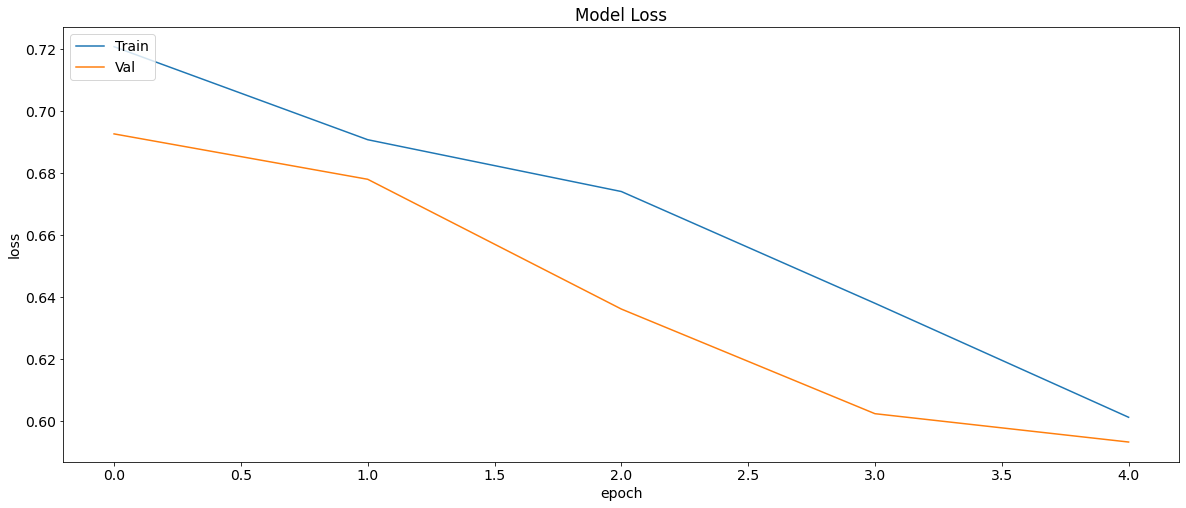

In [13]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

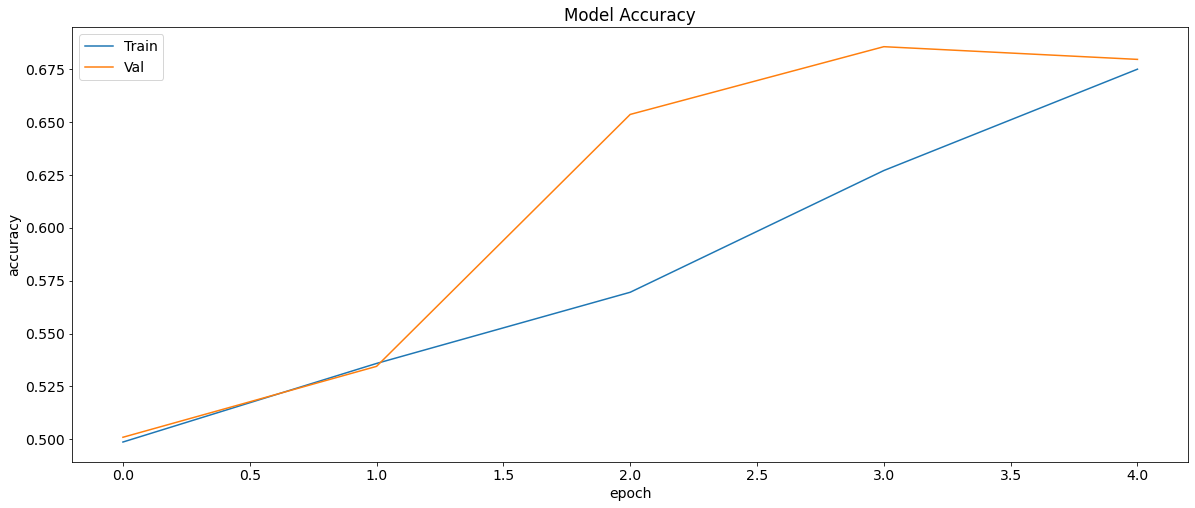

In [14]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [15]:
model = tf.keras.models.load_model('/kaggle/working/model_cnn.h5')

In [18]:
y_test = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_probs = y_pred.copy()

In [20]:
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

# Evaluation of Classification Model 

<img src='https://learnanalyticshere.files.wordpress.com/2021/02/image-1.png'>

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

## Classification Report

In [22]:
print(classification_report(y_test,y_pred,target_names = ['cats','dogs']))

              precision    recall  f1-score   support

        cats       0.73      0.56      0.64      1000
        dogs       0.65      0.80      0.71      1000

    accuracy                           0.68      2000
   macro avg       0.69      0.68      0.68      2000
weighted avg       0.69      0.68      0.68      2000



## Confusion Matrix

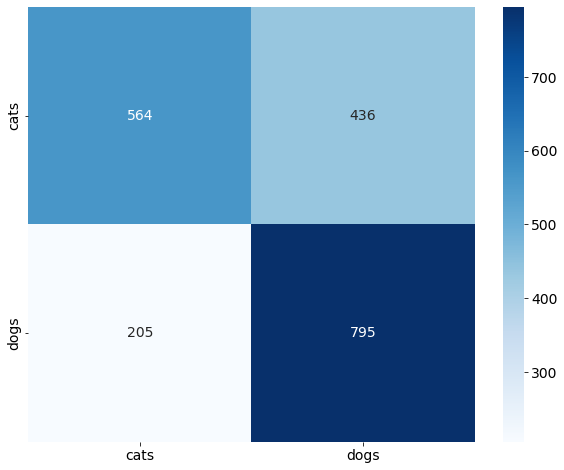

In [23]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=['cats','dogs'],
            yticklabels=['cats','dogs'],cmap='Blues')
plt.show()

In [28]:
#y_axis=predicted,x-axis=actual

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

In [26]:
roc_auc

0.762182

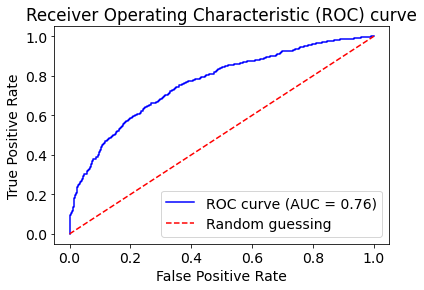

In [27]:
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.show()

# Model Diagnosis
- Understanding the distribution of misclassification probabilities
- Visualizing the feature maps of each layer
- Visualizing the image embeddings (last but one layer's vector outputs) in 2D space using dimensionality reduction
    - PCA
    - t-SNE
    
<img src='https://miro.medium.com/max/1400/1*OuxhgVj1WDDfo5UO5GIhgA@2x.png'>

## Prediction Meta-Data
- Create a dataframe that stores the actual and predicted classes for the images as well as the prediction probabilities
- Since 0 is cat and 1 is dog, the higher the probability value the more confident the model is that the image is of a dog and the lower the probability the more confident the models is that the image is of a cat

In [ ]:
filenames = validation_generator.filenames
data = pd.DataFrame()
data['filename'] = filenames
data['actual_class'] = y_test
data['predicted_class'] = y_pred
data['predicted_prob'] = y_pred_probs

In [ ]:
misclassification = data[data['actual_class']!=data['predicted_class']]

## IQR and Histogram Analysis of Cats misclassified as Dogs

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(x=misclassification[misclassification['actual_class']==0]['predicted_prob'])
plt.show()

## Histogram Inference
- Here you can see that most of the misclassification lie in the 0.5-0.6 bin, i.e. the borderline of our probability threshold
- However it is a curious case that some misclassifications have probability > 0.8

In [ ]:
plt.figure(figsize=(20,5))
sns.histplot(misclassification[misclassification['actual_class']==0]['predicted_prob'],bins=5)
plt.show()

## Visualization of Misclassification Samples

In [ ]:
misclassification[(misclassification['actual_class']==0) & (misclassification['predicted_prob']>0.9)]

## Visualization of High Confidence Misclassifications
- Its due to either being an incorrectly labelled image 
- Due to it being a clipart image where the prominent features of cat are not quite visible
- Positon of a cat in an image where its snout appears to be dog like due to its side ways appearance
- Whiskers which are more prominent features of cats are maybe not visible in some of the images

In [ ]:
img = load_img('/kaggle/input/dogs-cats-images/dataset/test_set/cats/cat.4085.jpg',target_size=(150,150))
img = img_to_array(img)/255.
plt.imshow(img)

In [ ]:
img = load_img('/kaggle/input/dogs-cats-images/dataset/test_set/cats/cat.4119.jpg',target_size=(150,150))
img = img_to_array(img)/255.
plt.imshow(img)

In [ ]:
img = load_img('/kaggle/input/dogs-cats-images/dataset/test_set/cats/cat.4833.jpg',target_size=(150,150))
img = img_to_array(img)/255.
plt.imshow(img)

In [ ]:
img = load_img('/kaggle/input/dogs-cats-images/dataset/test_set/cats/cat.4827.jpg',target_size=(150,150))
img = img_to_array(img)/255.
plt.imshow(img)

## Feature Map Visualization
- Visualization of the outputs of the intermediate layers

In [ ]:
img = load_img('/kaggle/input/dogs-cats-images/dataset/test_set/cats/cat.4144.jpg',target_size=(150,150))
img = img_to_array(img)/255.

In [ ]:
plt.imshow(img)

### We add an additional dimension even when we have to predict the class of one image

In [ ]:
img = np.expand_dims(img,axis=0)
img.shape

### Pick a layer by indexing the layers list
- Plug the index value of that layer to generate its output for a particular image

In [ ]:
model.layers

In [ ]:
layer_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
feature_maps = layer_model.predict(img)

In [ ]:
feature_maps.shape

### 15 Feature Map Samples from First Conv2D Layer
- Feel free to experiment around with different layer values
- You can see the different types of filter outputs for the first 15 filters of the first Conv2D layer

In [ ]:
plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(feature_maps[0,:,:,i])
    plt.axis('off')

## Image Embeddings Visualization
- Use the output of the last but one layer i.e. the layer before the output layer. The vector output is known as **Embeddings**
- Shape of the embeddings will be No. of images x Hidden Layer units
- Apply PCA/t-SNE on the feature output and reduce it 2D
- **Note**: 2 components may not capture the required amount of variance explanation. This is only to be able to visualize the image embeddings in 2D

In [ ]:
feature_extractor = Model(model.inputs,model.layers[-2].output)

In [ ]:
features = feature_extractor.predict(validation_generator)

In [ ]:
features.shape

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
pca = PCA(2)
pc_features = pca.fit_transform(features)

In [ ]:
pc_features

In [ ]:
data[['PC1','PC2']] = pc_features

In [ ]:
data

In [ ]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [ ]:
fig = px.scatter(data, x="PC1", y="PC2", color="actual_class", hover_data=['filename'])
fig.show()

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(features)

In [ ]:
X_embedded

In [ ]:
data[['Axis1','Axis2']] = X_embedded

In [ ]:
fig = px.scatter(data, x="Axis1", y="Axis2", color="actual_class", hover_data=['filename'])
fig.show()

## How to use above plots ?
- Try to observe the images whose embeddings are appearing closer they must be having some similar kind of features
- Refer to the misclassifications table to understand why exactly did an image get misclassified